In [1]:
# general imports for project
import pandas as pd
import numpy as np
import os
from keras.preprocessing.image import load_img, img_to_array
from keras.callbacks import ModelCheckpoint, EarlyStopping

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# "Sequential" model lets us to define a stack of neural network layers
from keras.models import Sequential

# import the "core" layers:
from keras.layers import Dense, Dropout, Activation, Flatten

# CNN
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D

# import some utilities to transform our data
from keras.utils import np_utils

# relative path
DATA_FILES_PATH = './testData/'

# image size tuple
IMAGE_SIZE = (64, 64)

Using TensorFlow backend.


# Read the csv to get the labels for the photos
- we will then map the relative filepath and which dataset the file is in into the original dataframe for later use


In [2]:
# loading labels.csv
LABELS = pd.read_csv(os.path.join(DATA_FILES_PATH, 'labels.csv'))

# get the actual filepaths from the id
def map_filepath_to_df(base_path, label_df):
    train_names = set(os.listdir(f'{DATA_FILES_PATH}train/'))
    test_names = set(os.listdir(f'{DATA_FILES_PATH}train/'))
    label_df['image_path'] = [
        f'{DATA_FILES_PATH}train/{row["id"]}.jpg' if
        f'{row["id"]}.jpg' in train_names else
        f'{DATA_FILES_PATH}test/{row["id"]}.jpg'
        for index, row
        in label_df.iterrows()
    ]
    

map_filepath_to_df(DATA_FILES_PATH, LABELS)

# describe the dataset
LABELS.head()

,id,breed,image_path
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull,./testData/train/000bec180eb18c7604dcecc8fe0db...
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo,./testData/train/001513dfcb2ffafc82cccf4d8bbab...
2,001cdf01b096e06d78e9e5112d419397,pekinese,./testData/train/001cdf01b096e06d78e9e5112d419...
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick,./testData/train/00214f311d5d2247d5dfe4fe24b23...
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever,./testData/train/0021f9ceb3235effd7fcde7f7538e...


# Let's describe the dataset

In [3]:
LABELS.pivot_table(index='breed',aggfunc=len).sort_values('id',ascending=True).describe()


,id,image_path
count,120.000000,120.000000
mean,85.183333,85.183333
std,13.298122,13.298122
min,66.000000,66.000000
25%,75.000000,75.000000
50%,82.000000,82.000000
75%,91.250000,91.250000
max,126.000000,126.000000


# Lets take a look at the breed distribution
- here Scottish Deerhound is shown the most and Briard is shown the least

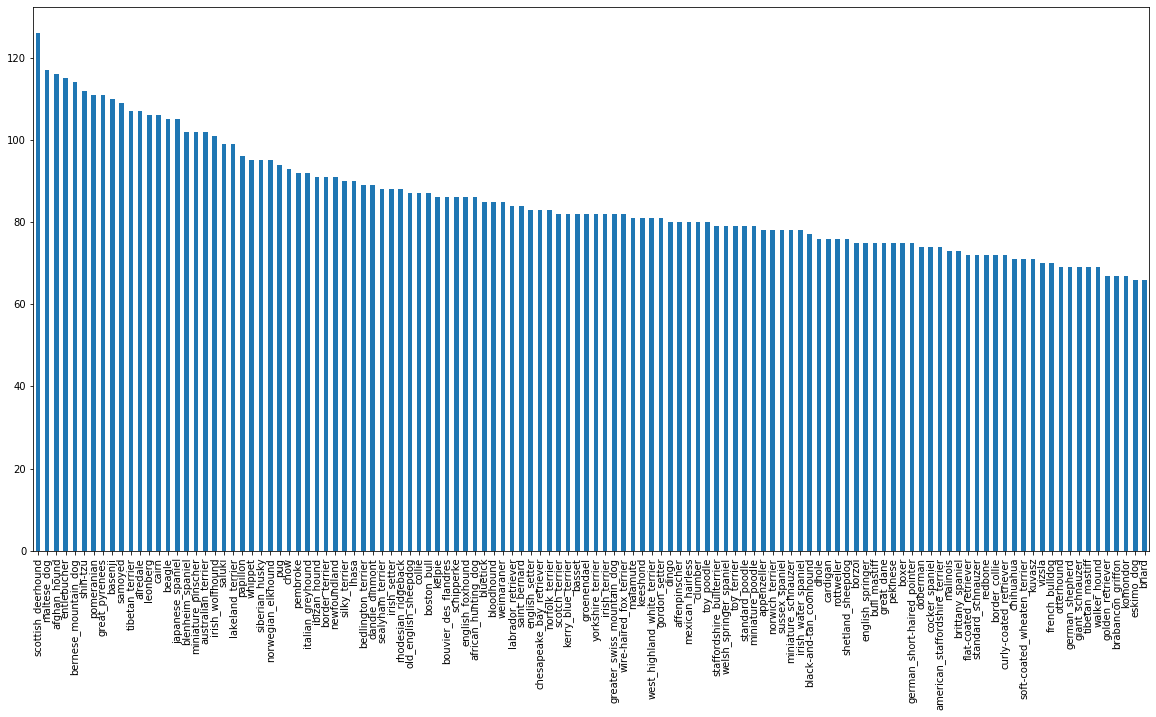

In [4]:
LABELS["breed"].value_counts().plot.bar(figsize=(20, 10))

# we can take a look at some of the images produced by load_image
- we will use load image later to produce a nparray of images


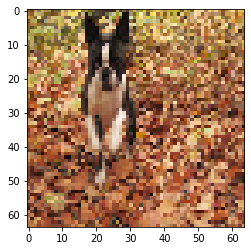

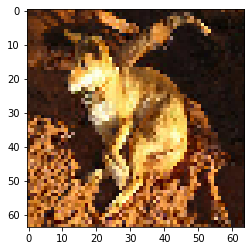

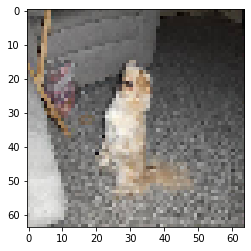

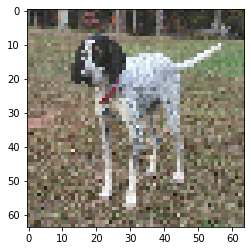

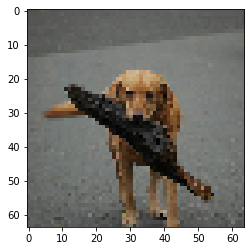

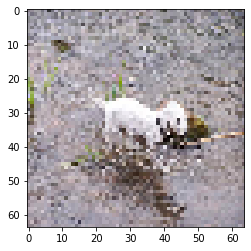

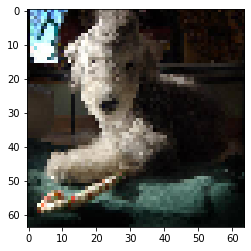

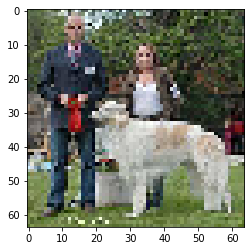

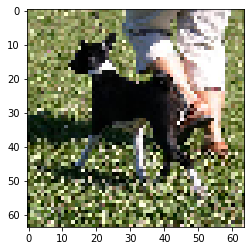

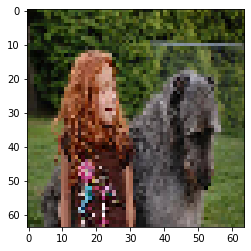

In [5]:
%matplotlib inline

for index, row in LABELS[:10].iterrows():
    plt.imshow(load_img(row['image_path'], target_size=IMAGE_SIZE))
    plt.show()

# first we need to load the images into the dataframe as image arrays, we can use img_to_array and load_image
- since we placed all the filepaths in the dataframe, we can do this is in a list comprehension 
np.expand_dims is used because 4d shaped is expected (num_images, width, height, num_channels). Our images will have
the shape (1, 224, 224, 3)
- the images can then be saved finally as a single vstack for train and test which will produce a shape of (num_samples, 224, 224, 3)

In [6]:
def load_images_to_size(labels_df):
    labels_df['image_array'] = [
        np.expand_dims(img_to_array(load_img(row['image_path'], target_size=IMAGE_SIZE)), axis=0)
        for index, row 
        in labels_df.iterrows()
    ]
    
def normalize_images(df):
    return np.vstack(df['image_array'].values).astype('float32')/255 # for rescaling the images

# add dataframe column to be used by keras
print('adding images...')
load_images_to_size(LABELS)

print('converting to vstack...')
X = normalize_images(LABELS)
label_encoder = LabelEncoder()
res = label_encoder.fit_transform(LABELS['breed'])
y = np_utils.to_categorical(res, 120)

print(X.shape)

adding images...
converting to vstack...
(10222, 64, 64, 3)


# since we would like to test our accuracy let's create a test and train subsection


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

print(X_train.shape)
print(X_test.shape)

(6848, 64, 64, 3)
(3374, 64, 64, 3)


# now lets create a base CNN model to use based off of our dataset
    

In [8]:
def get_model():
    model = Sequential()

    model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=(64, 64, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
    print(model.output_shape)
    model.add(Dropout(0.3))

    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
    print(model.output_shape)

    model.add(Flatten())

    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(120, activation='softmax'))
    print(model.output_shape)

    return model
    
my_cnn = get_model()

(None, 31, 31, 16)
(None, 14, 14, 32)
(None, 120)


# compile the model

In [9]:
my_cnn.compile(loss='categorical_crossentropy',metrics=['accuracy'],
              optimizer='adam')

print(my_cnn.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 16)        448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 31, 31, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)              

# fit the model

In [10]:
checkpointer = ModelCheckpoint(filepath='./saved_models/my_cnn_best_weights.hdf5', verbose=1, save_best_only=True)

# history = model.fit(X_train, y_train, batch_size=32, epochs=3, verbose=1)
history = my_cnn.fit(X_train, y_train, validation_split=0.25, batch_size=15, epochs=25, callbacks=[checkpointer], verbose=1)

# batch_size: Integer or None. Number of samples per gradient update. 
# epochs: Number of iteration over the entire x and y data provided. 
# verbose: 0, 1, or 2. how want to see the training progress. 0 = silent, 1 = progress bar, 2 = one line per epoch.
# validation_split: Float between 0 and 1. Fraction of the training data to be used as validation data. 
# You can add some callbacks to get a view on internal states and statistics of the model during training:
# https://keras.io/callbacks/     

Train on 5136 samples, validate on 1712 samples
Epoch 1/25
5136/5136 [==============================] - 37s 7ms/step - loss: 4.7959 - accuracy: 0.0109 - val_loss: 4.7703 - val_accuracy: 0.0239

Epoch 00001: val_loss improved from inf to 4.77035, saving model to ./saved_models/my_cnn_best_weights.hdf5
Epoch 2/25
5136/5136 [==============================] - 44s 9ms/step - loss: 4.7215 - accuracy: 0.0212 - val_loss: 4.6675 - val_accuracy: 0.0251

Epoch 00002: val_loss improved from 4.77035 to 4.66745, saving model to ./saved_models/my_cnn_best_weights.hdf5
Epoch 3/25
5136/5136 [==============================] - 34s 7ms/step - loss: 4.5378 - accuracy: 0.0350 - val_loss: 4.5282 - val_accuracy: 0.0374

Epoch 00003: val_loss improved from 4.66745 to 4.52825, saving model to ./saved_models/my_cnn_best_weights.hdf5
Epoch 4/25
5136/5136 [==============================] - 29s 6ms/step - loss: 4.2530 - accuracy: 0.0717 - val_loss: 4.4381 - val_accuracy: 0.0432

Epoch 00004: val_loss improved from 

KeyboardInterrupt: 

# load the best weights


In [11]:
my_cnn.load_weights('./saved_models/my_cnn_best_weights.hdf5')

NameError: name 'my_cnn' is not defined

# plot out progress

In [12]:
%matplotlib inline

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'b-', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r-', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

NameError: name 'history' is not defined

# the accuracy is not too great here, could be due to a low amount of images.
- our next step would be to use a image generator to generate new images from our existing images by performing transformations on them
- this includes flipping the image, etc.